# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В ходе работы предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В моём распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

### Тариф "Смарт"

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- Минута разговора: 3 рубля
- Сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей


### Тариф "Ультра"

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- Минута разговора: 1 рубль
- Сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей


Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

# Описание данных


#### Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок


#### Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя


#### Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение


#### Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана


#### Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Шаг 1. Открою файл с данными и изучу общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import math
from scipy import stats as st

In [2]:
!pip install plotly

#### 1.1. Откроем файлы

In [3]:
try:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except:
    calls = pd.read_csv('D:/repository/projects/3_статистический анализ/calls.csv')
    internet = pd.read_csv('D:/repository/projects/3_статистический анализ/internet.csv')
    messages = pd.read_csv('D:/repository/projects/3_статистический анализ/messages.csv')
    tariffs = pd.read_csv('D:/repository/projects/3_статистический анализ/tariffs.csv')
    users = pd.read_csv('D:/repository/projects/3_статистический анализ/users.csv')
    
pd.set_option('display.max_columns', 50)    

#### 1.2. Изучим общую информацию

In [4]:
for data in [calls, internet, messages, users, tariffs]: print(data.head(), end='\n\n\n')

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000


   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000


       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000


   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1

In [5]:
for data in [calls, internet, messages, users, tariffs]: print(data.info(), end='\n\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


<class 'pandas.core.f

In [6]:
for data in [calls, internet, messages, users, tariffs]: print(data.describe(), end='\n\n\n')

            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000


          Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000


             user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000


           user_id    

#### 1.3. Проверим наличие пропусков

In [7]:
for data in [calls, internet, messages, users, tariffs]: print(data.isna().sum(), end='\n\n\n')

id           0
call_date    0
duration     0
user_id      0
dtype: int64


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64


id              0
message_date    0
user_id         0
dtype: int64


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64


messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64




#### 1.4. Проверим на наличие дубликатов

In [8]:
for data in [calls, internet, messages, users, tariffs]: print(data.duplicated().sum(), end='\n')

0
0
0
0
0


## Итог

#### Пропуски и дубликаты

Пропусков и дубликатов в таблице не имеется, за исключением столбца churn_date в таблице users, но как сказано в условии - если значение пропущено, то тариф ещё действовал на момент выгрузки данных, слудовательно эти пропуски трогать не будем, оставляем как есть. 

#### Замена типов данных

В таблицах calls, internet, messages, users имеются столбцы с датой и временем. переведём тип этих столбцов к datetime. Столбцы duration, mb_used округлим вверх до целых значений, как указано в условии, заменим тип данных на целочисленный.

#### Ошибки и неверные значения 

В таблицах calls (столбец duration) и internet (столбец mb_used) присутствуют нулевые значения. Проверю что за значения и постараюсь от них избавиться по ходу работы.

# Шаг 2. Подготовка данных

### 2.1. Обработка пропусков и замена типов данных

#### 2.1.1. Заменим тип данных в столбцах с датой по всем таблицам

In [9]:
dtformat = '%Y-%m-%d'

def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=dtformat)
to_datetime(calls, ['call_date'])
to_datetime(internet, ['session_date'])
to_datetime(messages, ['message_date'])
to_datetime(users, ['reg_date', 'churn_date'])

#### 2.1.2. Приведём в пордок столбец  duration из таблицы calls

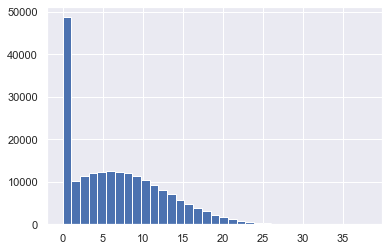

In [10]:
# построим гистограмму распределения 
calls['duration'].hist(bins=35, grid=True)
plt.show()

Нулевых значений подавляющее большинство. Звонок либо не состоялся, по той или иной причине, либо значения просто не округлились. Заменим нулевые значения и близкие к нулевому (до 1 секунды) на 1, т.к. оператор по условиям ТП минуты и мегабайты округляет вверх. Для округения использую функцию ceil из библиотеки numpy 

In [11]:
calls['duration'] = calls['duration'].replace(0, 1)

In [12]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int')

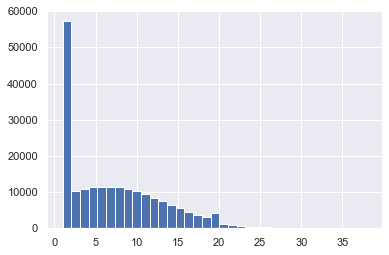

In [13]:
calls['duration'].hist(bins=35, grid=True)
plt.show()

После округления ничего не поменялось, нулевые значения так же имеются и их довольно много, почти 40000. Полаагаю, что нули появляются, когда звонок не состоялся, например линия была занята или абонент сбросил входящий вызов. Исходя из этого получается, что соединение было, но разговора не произошло, следоваательно оператору нечего округлять. Удалим нули и приведём столбец к целочисленному формату. Чтобы избавится от 0, заменим их на NaN и далее методоом dropna удалим NaN

#### 2.1.3. Приведём в пордок столбец  mb_used из таблицы internet

In [14]:
# сразу округлим значения до целых 
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

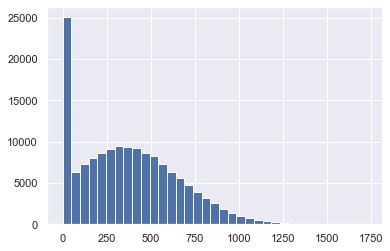

In [15]:
# построим гистограмму
internet['mb_used'].hist(bins=35, grid=True)
plt.show()

Округление не помогло избавиться от нулевых значений, полагаю, что нули появились после регистрации в сети, т.е. аппарат отправил базовой станции набор информационных пакетов, для своей регистрации в сети,  но даалее никаких действий не последовало. Аппарат проходит регистрацию всегда после вклчения и в случает, если пропадает сеть, н.п. человек мог зайтии в лифт. Так что считаю что избавиться от 0 будет так же справедливо, как и в  случае со звонками.

In [16]:
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet.dropna(subset=['mb_used'], inplace=True)

In [17]:
# заменим тип данных на целочисленный
internet['mb_used'] = internet['mb_used'].astype('int')

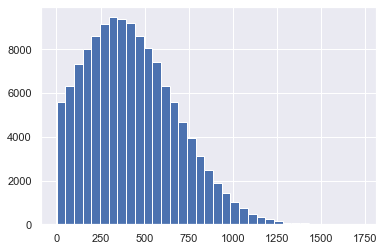

In [18]:
# ещё раз построим гистограмму
internet['mb_used'].hist(bins=35, grid=True)
plt.show()

#### Ответ на комментарий

Не совсем понял что именно не так с описанием. Нули заменил на единицы, всё таки оператор округляет значения вверх. Пика в районе 13 тоже пропала.

### 2.2. Подсчить для каждого пользователя

#### 2.2.1. Количество сделанных звонков и израсходованных минут разговора, количество отправленых сообщений, объём израсходованного интернет-трафика, по месяцам.

добавим столбец с месяцм в каждый фрейм

In [19]:
calls['month'] = calls['call_date'].dt.month

In [20]:
internet['month'] = internet['session_date'].dt.month

In [21]:
messages['month'] = messages['message_date'].dt.month

Склеим все необходимые данные в отдельный датафрейм, все значения пересекаются по user_id

Для этого составим ряд сводных таблиц, для дальнейшего объединения в одну

In [22]:
calls_users = calls.pivot_table(index=('user_id','month'), 
                                values='duration', 
                                aggfunc='sum', 
                                fill_value=0).fillna(0).reset_index()
calls_users.head()

,user_id,month,duration
0,1000,5,164
1,1000,6,187
2,1000,7,346
3,1000,8,418
4,1000,9,478


In [23]:
internet_users = internet.pivot_table(index=('user_id','month'),
                                      values='mb_used', 
                                      aggfunc='sum',
                                      fill_value=0).fillna(0).reset_index()
internet_users.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


Конвертируем мегабайты в гигабайты

In [24]:
messages_users = messages.pivot_table(index=('user_id', 'month'),
                                      values='message_date', 
                                      aggfunc='count',
                                      fill_value=0).fillna(0).reset_index()
messages_users.head()

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Объединяем таблицы

In [25]:
tariffs.rename(columns={'tariff_name' : 'tariff'}, inplace=True)

In [26]:
users_tariffs = users.merge(tariffs, on='tariff', how='left')
users_tariffs.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1


In [27]:
total = users_tariffs.merge(calls_users, on='user_id', how='left')
total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,5.0,164.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,6.0,187.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,7.0,346.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,8.0,418.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,9.0,478.0


In [28]:
total = total.merge(internet_users, on=['user_id', 'month'], how='left')
total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,5.0,164.0,2256.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,6.0,187.0,23257.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,7.0,346.0,14016.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,8.0,418.0,14070.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,9.0,478.0,14581.0


In [29]:
total = total.merge(messages_users, on=['user_id', 'month'], how='left')
total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used,message_date
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,5.0,164.0,2256.0,22.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,6.0,187.0,23257.0,60.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,7.0,346.0,14016.0,75.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,8.0,418.0,14070.0,81.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,9.0,478.0,14581.0,57.0


In [30]:
# Конвертируем мегабайты в гигабайты
def mb_per_gb(value):
    if value>0:
        return math.ceil(value / 1024)
    else: 
        return 0

#Применим функцию
total.mb_used = total.mb_used.apply(mb_per_gb)
total.mb_per_month_included = total.mb_per_month_included.apply(mb_per_gb)


## <span style="color:green">Комментарий от ревьювера </span>

Хорошо справляешся со сводными таблицами, классно "мёрджишь":) Молодец, это не так то легко, как кажется. Вижу, что и раньше и в дальшейшем, ты часто используешь функции. Это круто! Если одинаковый код повторяется больше двух раз, то это рутина. Рутину искореняем функциями:)

Проверим наличие пропусков

In [31]:
total.isna().sum()

user_id                     0
age                         0
churn_date               2993
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
month                       8
duration                    8
mb_used                     0
message_date              504
dtype: int64

Пропуски есть в столбцах mb_used (объём потраченого трафика) и message_date (дата сообщения) и duration (длителльность звонка). Полагаю абонент просто не пользовался какой-то из услуг связи. Оставляем как есть

#### 2.2.2. Подсчитаем помесячную выручку с каждого пользователя

Добавляю столбцы с перерасходом по минутам, интернет-трафику и смс для каждого абонента. Отрицательные значения означают, что есть остаток, который кл не успел потратить, положительные - показывают перерасход 

In [32]:
total['minutes_over']  = total['duration'] - total['minutes_included']
total['messages_over'] = total['message_date'] - total['messages_included']
total['mb_used_over']  = total['mb_used'] - total['mb_per_month_included']

In [33]:
def monthly_revenue(row):

    minutes_price = 0
    messages_price = 0
    mb_used_price = 0
    
    # стоимость доп минут
    if row['minutes_over'] > 0:
        minutes_price = row['minutes_over'] * row['rub_per_minute']

    # стоимость доп смс
    if row['messages_over'] > 0:
        messages_price = row['messages_over'] * row['rub_per_message']

    # стоимость доп трафика
    if row['mb_used_over'] > 0:
        mb_used_price = row['mb_used_over'] * row['rub_per_gb']
    
    return minutes_price + messages_price + mb_used_price

In [34]:
total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used,message_date,minutes_over,messages_over,mb_used_over
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,5.0,164.0,3,22.0,-2836.0,-978.0,-27
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,6.0,187.0,23,60.0,-2813.0,-940.0,-7
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,7.0,346.0,14,75.0,-2654.0,-925.0,-16
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,8.0,418.0,14,81.0,-2582.0,-919.0,-16
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,9.0,478.0,15,57.0,-2522.0,-943.0,-15


Подсчитаю выручку с каждого абонента в месяц

In [35]:
total['rub_monthly_fee_over'] = total.apply(monthly_revenue, axis=1)
total['rub_monthly_fee_total'] = total['rub_monthly_fee'] + total['rub_monthly_fee_over']

In [36]:
total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used,message_date,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,5.0,164.0,3,22.0,-2836.0,-978.0,-27,0.0,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,6.0,187.0,23,60.0,-2813.0,-940.0,-7,0.0,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,7.0,346.0,14,75.0,-2654.0,-925.0,-16,0.0,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,8.0,418.0,14,81.0,-2582.0,-919.0,-16,0.0,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,9.0,478.0,15,57.0,-2522.0,-943.0,-15,0.0,1950.0


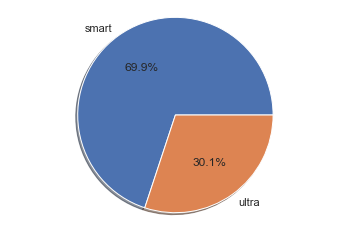

In [37]:
vals = total.groupby('tariff')['user_id'].count()
labels = ['smart', 'ultra']

fig, ax = plt.subplots()
ax.pie(vals, autopct='%1.1f%%', shadow=True, labels=labels)
ax.axis("equal")
plt.show()

Для убовства отображения данных можно оставить только нужные столбцы в датафрейме

In [38]:
new_total = pd.DataFrame(
    total[['user_id', 'city', 'reg_date', 'tariff',
           'messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
           'rub_per_gb', 'rub_per_message', 'rub_per_minute',
           'month', 'duration', 'mb_used','message_date', 'minutes_over', 'messages_over',
           'mb_used_over', 'rub_monthly_fee_over', 'rub_monthly_fee_total']]
)
new_total.head()

,user_id,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used,message_date,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,5.0,164.0,3,22.0,-2836.0,-978.0,-27,0.0,1950.0
1,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,6.0,187.0,23,60.0,-2813.0,-940.0,-7,0.0,1950.0
2,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,7.0,346.0,14,75.0,-2654.0,-925.0,-16,0.0,1950.0
3,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,8.0,418.0,14,81.0,-2582.0,-919.0,-16,0.0,1950.0
4,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,9.0,478.0,15,57.0,-2522.0,-943.0,-15,0.0,1950.0


In [39]:
new_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 20 columns):
user_id                  3182 non-null int64
city                     3182 non-null object
reg_date                 3182 non-null datetime64[ns]
tariff                   3182 non-null object
messages_included        3182 non-null int64
mb_per_month_included    3182 non-null int64
minutes_included         3182 non-null int64
rub_monthly_fee          3182 non-null int64
rub_per_gb               3182 non-null int64
rub_per_message          3182 non-null int64
rub_per_minute           3182 non-null int64
month                    3174 non-null float64
duration                 3174 non-null float64
mb_used                  3182 non-null int64
message_date             2678 non-null float64
minutes_over             3174 non-null float64
messages_over            2678 non-null float64
mb_used_over             3182 non-null int64
rub_monthly_fee_over     3182 non-null float64
rub_monthly_fee

Округлим до целых и заменим тип столбцов на целочисленный

In [40]:
columns = ['duration', 'mb_used', 'message_date', 'minutes_over', 'messages_over', 'mb_used_over']

for col in columns:
    
    new_total[col] = new_total[col].apply(np.ceil)

In [41]:
columns = ['month', 'duration', 'mb_used', 'message_date', 'minutes_over', 'messages_over', 'mb_used_over',
           'rub_monthly_fee_over', 'rub_monthly_fee_total']

for col in columns:
    
    new_total[col] = new_total[col].fillna(0).astype('int')

### Итог

В ходе работы сформировал отдельный фрейм данных, в рамках которого есть информация по абонентам, количеству минут, смс, и интернет-трафика, которое абонент израсходовал. Поменял тип на целочисленный, округлил до целых вверх. Так же подсчитал какие абоненты не укладываются в предоставляемые пакеты и какую сумму переплачивают. Узнал, что основная масса абонентов (70 %) пользуется ТП "Смарт". Таблица полностью пригодна для дальнеёшего анализа.

# Шаг 3. Анализ данных

Опишу поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаю среднее количество, дисперсию и стандартное отклонение. Визуализирую данные.

### 3.1. Посчитаю, сколько в среднем каждому пользователю требуется минут, сообщений и гигабайт в месяц

In [42]:
new_total.head()

,user_id,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,duration,mb_used,message_date,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,5,164,3,22,-2836,-978,-27,0,1950
1,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,6,187,23,60,-2813,-940,-7,0,1950
2,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,7,346,14,75,-2654,-925,-16,0,1950
3,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,8,418,14,81,-2582,-919,-16,0,1950
4,1000,Краснодар,2018-05-25,ultra,1000,30,3000,1950,150,1,1,9,478,15,57,-2522,-943,-15,0,1950


In [43]:
average_for_user = new_total.pivot_table(index='user_id', 
                                         values=['duration', 'message_date', 'mb_used', 'rub_monthly_fee_total'],
                                         aggfunc='median')
for user_id in users['user_id']:
    average_for_user.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
average_for_user.head()

,duration,mb_used,message_date,rub_monthly_fee_total,tariff
user_id,,,,,
1000,345.0,14.5,65.0,1950.0,ultra
1001,437.0,16.5,0.0,950.0,smart
1002,221.0,18.0,11.0,1150.0,smart
1003,844.0,12.0,83.0,1950.0,ultra
1004,136.5,18.0,154.5,1950.0,ultra


### 3.2. Посчитаю среднее количество, дисперсию и стандартное отклонение

In [44]:
values=['duration', 'mb_used', 'message_date']

In [45]:
desc_stat = average_for_user.pivot_table(index=['tariff'], values=values, 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'message_date': [np.median, np.var, np.std]})
desc_stat.apply(np.ceil)

duration                 mb_used             message_date              
         median    std      var  median   std   var       median   std     var
tariff                                                                        
smart     452.0  167.0  27595.0    17.0   5.0  19.0         29.0  29.0   789.0
ultra     550.0  314.0  98557.0    20.0  10.0  89.0         47.0  49.0  2384.0

### 3.3. Визуализация данных

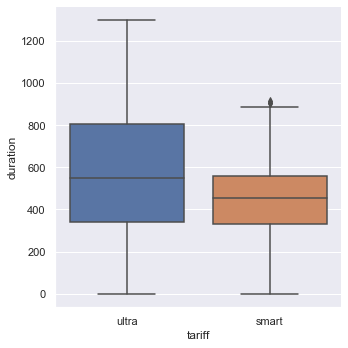

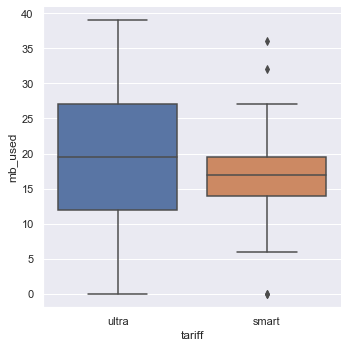

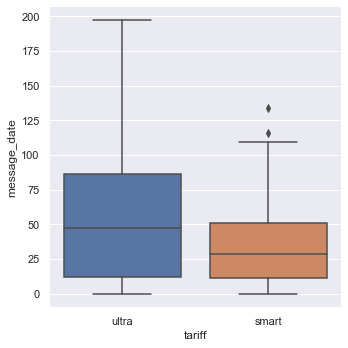

In [46]:
for value in values:    
    sns.catplot(x="tariff", y=value, kind="box", data=average_for_user, orient='v')

Минуты разговора, интернет-трафик, количество сообщений на ТП ultra имеют большее среднее, дисперсия и стандартное отклонение так же выше, по сравнению с ТП smart. На ТП smart больше выбросов - это значит, что многие абоненты тратят трафика больше, чем заложено в ТП. 

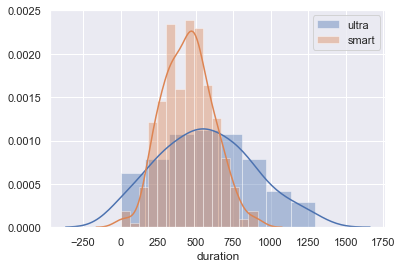

In [47]:
for tariff in ['ultra', 'smart']:
    sns.distplot(average_for_user.query('tariff == @tariff')['duration'], kde=True, label=tariff)
    plt.legend(['ultra', 'smart'])

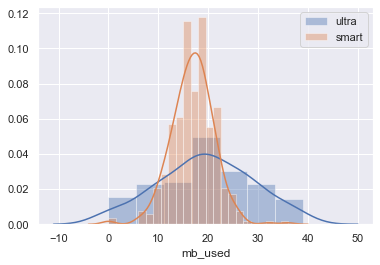

In [48]:
for tariff in ['ultra', 'smart']:
    sns.distplot(average_for_user.query('tariff == @tariff')['mb_used'], kde=True, label=tariff)
    plt.legend(['ultra', 'smart'])

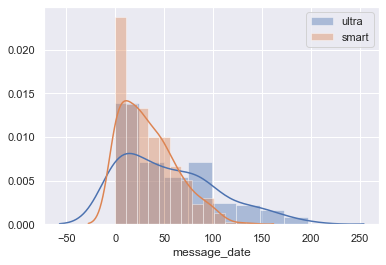

In [49]:
for tariff in ['ultra', 'smart']:
    sns.distplot(average_for_user.query('tariff == @tariff')['message_date'], kde=True, label=tariff)
    plt.legend(['ultra', 'smart'])

Статистика оплаты за ТП

In [50]:
tariff_usage = new_total.pivot_table(
    index='tariff',
    values=['rub_monthly_fee_over', 'rub_monthly_fee_total']
)
tariff_usage

,rub_monthly_fee_over,rub_monthly_fee_total
tariff,,
smart,761.905618,1311.905618
ultra,121.159875,2071.159875


### Итог


Как выяснил ранее большинство пользуется ТП smart, из этих абонентов многие переплачивают, т.к. не укладываются в объём минут, интернет-трафика и соообщений, предусмотренный тарифом(отлично видно из статистики оплаты).  Это не так сильно отражается по звонкам, как по интернет-трафику. Исходя из этого делаю вывод, что интернет абонентам важен больше, чем голосовой трафик.

Не смотря на то что ТП smart более популярный и за него гораздо чаще абоненты переплачивают, больше прибыли компании приносит ТП ultra.

# Шаг 4. Проверка гипотез

Для проверки гипотез отлично подойдёт статистический критерий Стьюдента, т.к. работаю с количественным типом данных, распределения похожи на нормальные - это видно по графикам (пункт 3.3.), исследую 2 независимые  выборки. Нулевая гипотеза уже сформулировала, альтернативная формируется исходя из нулевой. Уровень значимости установим 5%.

### 4.1. Средняя выручка по тарифам во всех регионах

H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны. 

H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [51]:
smart = new_total.query("tariff=='smart'")['rub_monthly_fee_total']
ultra = new_total.query("tariff=='ultra'")['rub_monthly_fee_total']

In [52]:
alpha = 0.05

results = st.ttest_ind(smart, ultra, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.144477381957578e-231
Отвергаем нулевую гипотезу


Ранее полученые данные подтвердились. Пользователи ТП smart и пользователи ТП ultra платят разные суммы за свои ТП, не смотря на то что за ТП smart абоненты обычно переплачивают.

### 4.1.Средняя выручка пользователей из Москвы

H0 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H1 - средняя выручка пользователей из Москвы  не отличается от выручки пользователей из других регионов.

In [53]:
moscow = new_total.query('city == "Москва"')['rub_monthly_fee_total']
regions = new_total.query('city != "Москва"')['rub_monthly_fee_total']

alpha = 0.05

results = st.ttest_ind(
    moscow, regions, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.48093855156785537
Не получилось отвергнуть нулевую гипотезу


Это логично, т.к. цены на ТП во всех регионах одинаковые. Резонно было бы предположить что выручка пользователей из МСК выше, если бы цены на ТП в этом регионе были выше, что логично и так есть в действительности. 


# Шаг 5. Общий вывод

По результатам анализа выяснил:

1) что доходы от ТП "Ультра" выше, чем от ТП "Смарт". В среднем оператор получает 2071 и 1295 рублей соответственно.

Следовательно нужно продвигать ТП "Ультра", исходя из генеральной совокупности этот ТП не так популярен, как хотелось бы оператору.

2) переплата за ТП "Смарт" и "Ультра" 745 и 121 рублей соответственно.

Отсюда делаю вывод, что ТП "Смарт" не подходит многим абонентам. Но не смотря на это им всё равно продолжают пользоваться, т.к. выходит дешевле, чем полатить за ТП "Ультра". Возможно есть смысл сделать промежуточный ТП, со средней АП и более объёмным количеством интернет-трафика (полагаю, что около 20 гигабайт будет приемлимо), и увеличить пакет минут до 600. 


**На мой взгляд таким ТП можно будет привлечь большее количество абонентов.**